# Using MIDI synthesizer on Android
MIDI synthesizer could be used with the [midistream](https://github.com/b3b/midistream) library.

In [1]:
%load_ext pythonhere
%connect-there

In [2]:
%%there
from midistream import Synthesizer
midi = Synthesizer()

Get syntesizer configuration:

In [3]:
%%there
from pprint import pprint 
pprint(midi.config)

{'buildGUID': b'1feda229-b9a8-45e9-96f4-73c0a80e7220',
 'buildTimeStamp': 1195621085,
 'checkedVersion': 0,
 'filterEnabled': 1,
 'libVersion': 50727438,
 'ma3xVoices': 64,
 'mixBufferSize': 128,
 'numChannels': 2,
 'sampleRate': 22050}


## Execute MIDI commands

In [4]:
%%there
midi.write([0x90, 60, 127])

* **0x90** - code for MIDI event **Note ON**  on channel **0**
* **60** - **C4** (middle C) note number
* **127** - maximum velocity

MIDI commands reference:

* [https://en.wikipedia.org/wiki/MIDI#Messages](https://en.wikipedia.org/wiki/MIDI#Messages)

* [https://www.midi.org/specifications-old/item/table-1-summary-of-midi-message](https://www.midi.org/specifications-old/item/table-1-summary-of-midi-message)


Off middle C note:

In [5]:
%%there
midi.write([0x80, 60, 127])

## Helpers
[midistream.helpers](https://midistream.readthedocs.io/en/latest/#module-midistream.helpers) module could be used to construct MIDI messages

In [6]:
%%there
from midistream.helpers import (
    Control,
    Note,
    midi_control_change,
    midi_note_on,
    midi_note_off,
    midi_channels,
    midi_instruments,
    midi_program_change,
    note_name,
)

In [7]:
%%there
program = 44
print(f"Change program on channel 0 to: {midi_instruments[program]}")
midi.write(midi_program_change(program))
midi.write(midi_note_on(Note.Es4))

Change program on channel 0 to: Tremolo Strings


In [8]:
%%there -d 1
midi.write(midi_note_off(Note.Es4))

##  Channels
MIDI channels allows to play different parts at the same time.

16 channels are available, channel **9** is a persussion channel.

In [9]:
%%there
print(list(midi_channels()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]


Helpers functions accept an optional *channel* argument:

In [10]:
%%there
midi.write(midi_program_change(20, channel=1))
midi.write(midi_note_on(Note.A3, channel=1))

midi.write(midi_program_change(21, channel=2))
midi.write(midi_note_on(Note.E4, channel=2))

In [11]:
%%there -d 1
midi.write(midi_note_off(Note.A3, channel=1))

At this point, A3 note is off on channel **1**, but channel **2** is continue to sound.

In [12]:
%%there -d 1
midi.write(midi_note_off(Note.E4, channel=2))

## Control Change messages

In [13]:
%%there
midi.write(
    midi_control_change(Control.volume, 110) +
    midi_control_change(Control.modulation, 90) +
    midi_program_change(62) + 
    midi_note_on(Note.D3) + midi_note_on(Note.F3)
)

In [14]:
%%there -d 2
midi.write(midi_control_change(Control.all_sound_off))  # Turns off sounds on a channel instantly
midi.write(midi_control_change(Control.modulation, 0))

## Master volume and Reverb effect
are controlled with *Synthesizer* properties:

In [15]:
%%there
from midistream import ReverbPreset
midi.volume = 100  # Set maximum master volume
midi.reverb = ReverbPreset.ROOM  # Enable Room preset

## Repeating a note with Kivy Clock
Play note every second:

In [16]:
%%there
from kivy.clock import Clock

beat_program = 33
beat_note = Note.C3

def beat(_):
    midi.write(midi_program_change(beat_program, channel=1))
    midi.write(midi_note_on(beat_note, channel=1))

beat_event = Clock.schedule_interval(beat, .5)

Change playing instrument and note:

In [17]:
%%there -d 2
beat_note += 12
beat_program = 115

Stop the scheduled event:

In [18]:
%%there -d 2
Clock.unschedule(beat_event)

## Playing sequence with Kivy Animation

In [19]:
%%there kv
BoxLayout:

In [20]:
%%there
from kivy.properties import NumericProperty
from kivy.uix.label import Label

class NoteLabel(Label):
    """Play and show note."""
    prev_note = 0
    note = NumericProperty(Note.E2)
    font_size = 150

    def on_note(self, obj, note):
        note = int(note)  # animation produce float values
        if note == self.prev_note:  # do not repeat same note
            return
        self.text = f"{note} : {note_name(note):3}"
        self.prev_note = note
        midi.write(midi_note_on(note) + midi_note_on(note + 7))

In [21]:
%%there
from kivy.animation import Animation

root.clear_widgets()
widget = NoteLabel()
root.add_widget(widget)

midi.write(midi_program_change(36))
    
sequence = (
    Animation(note=widget.note + 6, duration=1.5, transition="in_elastic") +
    Animation(note=widget.note + 13, duration=1.5, transition="in_elastic") +
    Animation(note=widget.note, duration=4, transition="out_sine") +
    Animation(note=widget.note, duration=.8)
)
sequence.bind(on_complete=lambda *args: midi.write(midi_control_change(Control.all_sound_off)))
sequence.start(widget)

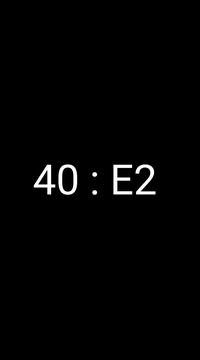

In [22]:
%there -d8 screenshot -w 200

## Instruments list

In [23]:
%%there kv
#:import midi_instruments midistream.helpers.midi_instruments

<InstrumentButton>:
    group: "instruments"
    text: "[b]{:3}[/b] : {}".format(self.instrument_code, midi_instruments[self.instrument_code])
    markup: True
    size_hint: 1, None
    text_size: self.size
    valign: "center"    
    padding_x: 40

ScrollView:
    do_scroll_x: False
    size_hint: 1, 1
    BoxLayout:
        id: instruments
        orientation: "vertical"
        size_hint: 1, None
        height: self.minimum_size[1]

In [24]:
%%there
from kivy.properties import NumericProperty
from kivy.uix.togglebutton import ToggleButton


class InstrumentButton(ToggleButton):
    instrument_code = NumericProperty()
    notes = Note.A3, Note.D4, Note.A5

    def on_state(self, widget, value):
        if value == "down":
            midi.write(midi_program_change(self.instrument_code))
            for note_code in self.notes:
                midi.write(midi_note_on(note_code))
        else:
            for note_code in self.notes:
                midi.write(midi_note_off(note_code))

for code in list(midi_instruments.keys()):
    root.ids.instruments.add_widget(InstrumentButton(instrument_code=code))

In [25]:
%there -d 1 screenshot -w 200